# Loading Sharadar Daily Bundle for Running the Zipline Pipeline

The notebook demonstrates and tests the interface for running the Zipline open-source research platform with the Sharadar Daily bundle (ingested with the daily_ingest notebook within this repository). The corresponding example consists of five steps: building the pipeline engine, building pipeline, running it, reading the Sharadar files for comparison with pipeline data, and testing pipeline data.

In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Importing the fsharadar.daily module from the Flounder extension

In [2]:
from fsharadar import daily

## 1. Building Pipeline Engine

Loading Sharadar daily bundle

In [3]:
daily_bundle_data = daily.load()

Defining bundle-specific pipeline loader

In [4]:
pipe_loader = daily.PipelineLoader(daily_bundle_data.equity_daily_bar_reader)

def get_pipe_loader(column):
    if column in daily.Fundamentals.columns:
        return pipe_loader
    raise ValueError("No PipelineLoader registered for column %s." % column)

Defining the Zipline pipeline engine

In [5]:
from zipline.pipeline.engine import SimplePipelineEngine

engine = SimplePipelineEngine(
    get_loader=get_pipe_loader,
    asset_finder=daily_bundle_data.asset_finder,
)

## 2. Building Pipeline

Reviewing characteristics of the bundle-specific FundamentalsDataSet

In [6]:
daily.Fundamentals.columns

frozenset({FundamentalsDataSet<US>.currency::object,
           FundamentalsDataSet<US>.ev::float64,
           FundamentalsDataSet<US>.evebit::float64,
           FundamentalsDataSet<US>.evebitda::float64,
           FundamentalsDataSet<US>.marketcap::float64,
           FundamentalsDataSet<US>.pb::float64,
           FundamentalsDataSet<US>.pe::float64,
           FundamentalsDataSet<US>.ps::float64})

In [7]:
from zipline.pipeline import Pipeline

pipe = Pipeline(
    columns={
        'ev': daily.Fundamentals.ev.latest,
        'evebit': daily.Fundamentals.evebit.latest,  
        'evebitda': daily.Fundamentals.evebitda.latest,   
        'marketcap': daily.Fundamentals.marketcap.latest,  
        'pb': daily.Fundamentals.pb.latest, 
        'pe': daily.Fundamentals.pe.latest,   
        'ps': daily.Fundamentals.ps.latest,           
    },
)

## 3. Running Pipeline

In [8]:
start_date = "2010-12-31"; end_date = "2021-02-23"

In [9]:
%%time
pipe_df = engine.run_pipeline(
    pipe,
    pd.Timestamp(start_date, tz='utc'),
    pd.Timestamp(end_date, tz='utc')
)

CPU times: user 7.43 s, sys: 1.2 s, total: 8.62 s
Wall time: 7.25 s


In [10]:
pipe_df.head(2)

ev  evebit  evebitda  \
2011-01-04 00:00:00+00:00 Equity(101501 [BBUCQ])  18.4    -9.4     -34.5   
                          Equity(101512 [GOVB])   42.2    28.3      26.2   

                                                  marketcap   pb    pe   ps  
2011-01-04 00:00:00+00:00 Equity(101501 [BBUCQ])        0.0  0.0   0.0  0.0  
                          Equity(101512 [GOVB])        21.3  1.0  21.8  4.4

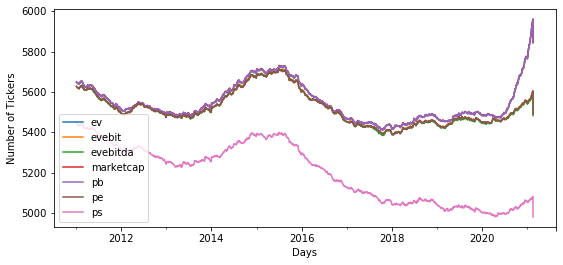

In [11]:
pipe_df.groupby(level=0).count().plot(figsize=(9, 4))
plt.xlabel('Days')
plt.ylabel('Number of Tickers')
plt.show()

In [12]:
print(len(pipe_df.index.levels[1]))

9258


## 4. Loading Sharadar daily file for testing pipeline data

In [13]:
sharadar_daily_file = "./SHARADAR_DAILY.csv"
usecols = ['ticker', 'date'] + daily.bundle_tags

In [14]:
%%time
sharadar_daily_df = pd.read_csv(sharadar_daily_file, parse_dates=['date'], usecols=usecols)

CPU times: user 12.2 s, sys: 454 ms, total: 12.7 s
Wall time: 12.7 s


In [15]:
raw_data = sharadar_daily_df.set_index(['date', 'ticker'])

In [16]:
raw_data.head(2)

ev  evebit  evebitda  marketcap   pb    pe   ps
date       ticker                                                     
2011-01-03 OCN     3010.3    26.4      20.4      974.8  1.1  26.0  3.0
           DCOM1   1553.4    24.2      23.3      524.6  1.6  13.5  4.2

## 5. Testing pipeline data

The following code runs through all the bundle characteristics (e.g., marketcap) and for each ticker checks for potential discrepencies between the time series from Zipline pipeline and Sharadar file. 

In [17]:
def check_assets(pipe_tag_df, raw_tag_df):
    
    pipe_tag_assets = pipe_tag_df.columns.values

    for i, asset in enumerate(pipe_tag_assets):

        ticker = asset.symbol
        
        asset_raw_ts = raw_tag_df[ticker].dropna()
        asset_pipe_ts = pipe_tag_df[asset].dropna() 
        
        # PipelineReader shifted data 'that would
        # be known at the **start** of each date'

        size = min(asset_raw_ts.size, asset_pipe_ts.size)
        if size < asset_raw_ts.size - 1:
            print(i, ticker, size)
        
        std_diff = np.std(asset_raw_ts.values[:size] - asset_pipe_ts.values[:size])
    
        if np.abs(std_diff) > 1.e-9 :
            print(i, ticker, std_diff)

In [19]:
for i, tag_name in enumerate(daily.bundle_tags):
    start = time.time()
    pipe_tag_df = pipe_df[tag_name].unstack()
    raw_tag_df = raw_data[tag_name].unstack() 
    check_assets(pipe_tag_df, raw_tag_df)
    end = time.time()
    print(i, tag_name, ', processing time:', end - start)

0 marketcap , processing time: 7.992377042770386
1 ev , processing time: 7.91681170463562
2 evebit , processing time: 8.014045715332031
3 evebitda , processing time: 7.893445730209351
4 pb , processing time: 7.853808403015137
5 pe , processing time: 7.791950702667236
6 ps , processing time: 7.797475099563599
